In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio
# from astropy.io import fits

In [18]:
params = {'legend.fontsize': 'medium',
          'axes.labelsize': 'medium',
          'axes.titlesize': 'medium',
          'xtick.labelsize': 'medium',
          'ytick.labelsize': 'medium',
          'figure.facecolor': 'w'}
plt.rcParams.update(params)

In [4]:
primary_columns = ['TARGETID', 'TILEID', 'LASTNIGHT', 'FIBER', 'DESI_TARGET', 'GOOD_SPEC']
extra_columns = ['TARGETID', 'Z', 'Z_QSO', 'GOOD_Z_QSO', 'SPECTYPE', 'SUBTYPE_NEW', 'GOOD_Z_QSO', 'Z_QSO']

fn = '/dvs_ro/cfs/cdirs/desicollab/users/rongpu/tmp/zcatalog/v0.4/main/ztile-main-dark-cumulative.fits'

cat = Table(fitsio.read(fn, columns=primary_columns))
cat_extra = Table(fitsio.read(fn.replace('.fits', '-extra.fits'), columns=extra_columns))
print(len(cat))
assert np.all(cat['TARGETID']==cat_extra['TARGETID'])
cat_extra.remove_column('TARGETID')
cat = hstack([cat, cat_extra], join_type='exact')
print(len(cat))

mask = cat['GOOD_SPEC']==True
cat = cat[mask]
print(len(cat))

33081000
33081000
27093411


In [5]:
mask_qso = cat['DESI_TARGET'] & 2**2 > 0  # QSO targets
mask_elg = cat['DESI_TARGET'] & 2**1 > 0  # ELG targets

In [6]:
zdiff_threshold = 0.003333  # 1000 km/s
mask_diff = np.abs((cat['Z_QSO'] - cat['Z'])/(1 + cat['Z'])) > zdiff_threshold
print('{:.2f}%'.format(100*np.sum(mask_diff)/len(mask_diff)))

0.71%


In [15]:
# Select objects with GALAXY best-fit from vanilla redrock and QSO best-fit from QSO afterburners
mask0 = mask_qso.copy()
mask0 &= cat['SPECTYPE']=='GALAXY'
print(np.sum(mask0))
mask0 &= cat['GOOD_Z_QSO'].copy()  # Z_QSO passes the QSO redshift quality cuts
print(np.sum(mask0))
mask0 &= (cat['Z_QSO']!=cat['Z'])
print(np.sum(mask0))
mask0 &= (~mask_diff)
print(np.sum(mask0))
print(np.sum(mask0 & mask_elg))

1422823
180842
169008
74470
30050


LOZ 72329
HIZ 2141


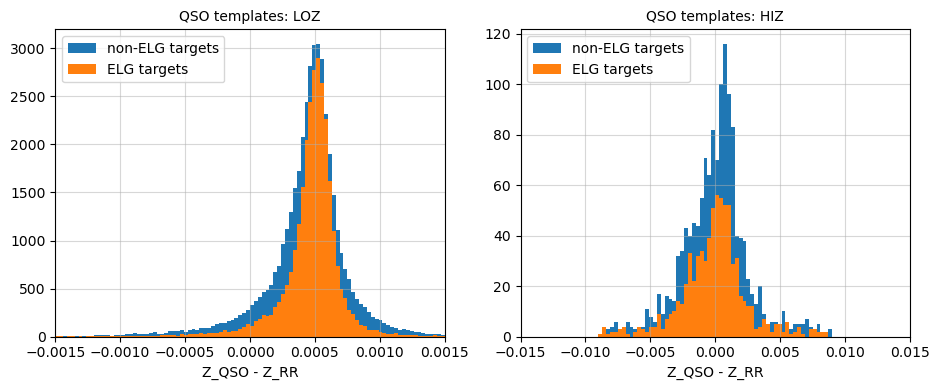

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(9.5, 4))

mask1 = cat['SUBTYPE_NEW']=='LOZ'
print('LOZ', np.sum(mask0 & mask1 & (~mask_diff)))
ax[0].hist((cat['Z_QSO']-cat['Z'])[mask0 & mask1 & (~mask_elg)], 100, range=(-0.0015, 0.0015), label='non-ELG targets')
ax[0].hist((cat['Z_QSO']-cat['Z'])[mask0 & mask1 & mask_elg], 100, range=(-0.0015, 0.0015), label='ELG targets')
ax[0].set_xlabel('Z_QSO - Z_RR')
ax[0].set_xlim(-0.0015, 0.0015)
ax[0].set_title('QSO templates: LOZ')
ax[0].legend(loc='upper left')
ax[0].grid(alpha=0.5)

mask1 = cat['SUBTYPE_NEW']=='HIZ'
print('HIZ', np.sum(mask0 & mask1 & (~mask_diff)))
ax[1].hist((cat['Z_QSO']-cat['Z'])[mask0 & mask1 & (~mask_elg)], 100, range=(-0.015, 0.015), label='non-ELG targets')
ax[1].hist((cat['Z_QSO']-cat['Z'])[mask0 & mask1 & mask_elg], 100, range=(-0.015, 0.015), label='ELG targets')
ax[1].set_xlabel('Z_QSO - Z_RR')
ax[1].set_xlim(-0.015, 0.015)
ax[1].set_title('QSO templates: HIZ')
ax[1].legend(loc='upper left')
ax[1].grid(alpha=0.5)
plt.tight_layout()
plt.show()

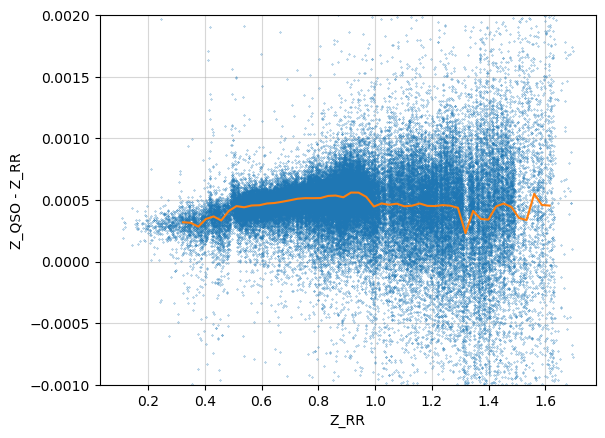

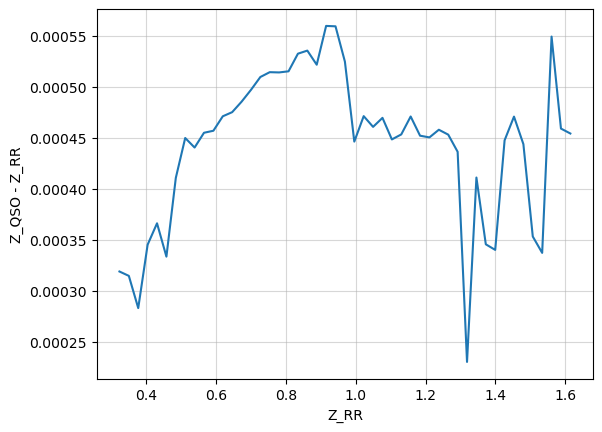

In [9]:
from scipy import stats

nmad = lambda x: 1.4826 * np.median(np.abs(x-np.median(x)))
error_of_the_mean = lambda x: nmad(x)/np.sqrt(len(x))

def binned_median(x, y, nbins=50):
    vmin, vmax = np.percentile(x, [0.5, 99.5])
    bins = np.linspace(vmin, vmax, nbins)
    bin_median, bin_edges, binnumber = stats.binned_statistic(x, y, statistic='median', bins=bins)
    bin_error, _, _ = stats.binned_statistic(x, y, statistic=error_of_the_mean, bins=bins)    
    bin_center = (bin_edges[1:] + bin_edges[:-1])/2
    return bin_center, bin_edges, bin_median, bin_error

bin_center, bin_edges, bin_median, bin_error = binned_median(cat['Z'][mask0], (cat['Z_QSO']-cat['Z'])[mask0])

plt.plot(cat['Z'][mask0], (cat['Z_QSO']-cat['Z'])[mask0], '.', ms=0.5)
plt.plot(bin_center, bin_median)
plt.grid(alpha=0.5)
plt.xlabel('Z_RR')
plt.ylabel('Z_QSO - Z_RR')
plt.ylim(-0.001, 0.002)
plt.show()

plt.plot(bin_center, bin_median)
plt.grid(alpha=0.5)
plt.xlabel('Z_RR')
plt.ylabel('Z_QSO - Z_RR')
# plt.ylim(-0.001, 0.002)
plt.show()

__Plot spectra__

In [10]:
sys.path.append(os.path.expanduser('~/git/desi-examples/misc/plot_spectrum'))
from desi_plot_spectrum import plot_spectrum

In [14]:
np.random.seed(999)
tids = np.random.choice(cat['TARGETID'][mask0], size=100, replace=False)
print(len(tids))

plot_dir = '/global/cfs/cdirs/desicollab/users/rongpu/plots/vi/more/z_qso_offset_5/'

if not os.path.isdir(plot_dir):
    os.makedirs(plot_dir)
    
def plot_spectra(tid):
    ii = np.where(cat['TARGETID']==tid)[0][0]
    tid, tileid, lastnight, petal, z, z_qso = cat['TARGETID'][ii], cat['TILEID'][ii], cat['LASTNIGHT'][ii], cat['FIBER'][ii]//500, cat['Z'][ii], cat['Z_QSO'][ii]
    coadd_fn_kibo = f'/dvs_ro/cfs/cdirs/desi/spectro/redux/loa/tiles/cumulative/{tileid}/{lastnight}/coadd-{petal}-{tileid}-thru{lastnight}.fits'
    plot_spectrum(coadd_fn_kibo, tid, use_targetid=True, show_model=True,
                 save_path=plot_dir+f'{tid}_z_rr.png', show=False, figsize=(44, 5), gauss_smooth=1)
    plot_spectrum(coadd_fn_kibo, tid, use_targetid=True, show_model=True, z=z_qso,
                 save_path=plot_dir+f'{tid}_z_qso.png', show=False, figsize=(44, 5), gauss_smooth=1)

# # Run this in interactive node
# from multiprocessing import Pool
# n_process = 64
# with Pool(processes=n_process) as pool:
#     res = pool.map(plot_spectra, tids)